In [1]:
import cuml
import chromadb
import numpy as np
from mlengine.core.model import umap, hdbscan

/home/yikuang/miniconda3/envs/rapids-defectsearch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chroma_client = chromadb.PersistentClient(path = "./data/chromadb/")
chroma_collection = chroma_client.get_collection("gh2024")

In [3]:
entries = chroma_collection.get(include=['embeddings', 'documents'])

In [4]:
entries.keys()

dict_keys(['ids', 'embeddings', 'metadatas', 'documents', 'uris', 'data', 'included'])

In [7]:
ids: np.ndarray = np.array(entries['ids'])
embeddings: np.ndarray = np.array(entries['embeddings'])
documents: np.ndarray = np.array(entries['documents'])
embeddings.shape, documents.shape

((11000, 768), (11000,))

#### Reduced Embeddings

In [8]:
reduced_embeddings: np.ndarray = umap(embeddings)
viz_embeddings: np.ndarray = umap(embeddings, n_components = 2)

[D] [09:23:43.616924] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:107 n_neighbors=25
[D] [09:23:43.617153] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:129 Calling knn graph run
[D] [09:23:43.691247] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:135 Done. Calling fuzzy simplicial set
[D] [09:23:43.692083] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:318 Smooth kNN Distances
[D] [09:23:43.692120] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:320 sigmas = [ 0.035566, 0.0698106, 0.0629611, 0.0263321, 0.022352, 0.0536458, 0.0607829, 2.94892e-05, 0.0488937, 0.0652817, 0.0565803, 0.0387475, 0.0242001, 0.038053, 0.0192625, 0.0122204, 0.0337952, 0.0100197, 0.029459, 0.0117886, 0.04187, 2.94892e-05, 0.02694, 0.0303205, 0.00845236 ]

[D] [09:23:43.692139] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:322 rhos = [ 0.717775, 0.880556, 0.692192, 0.241218, 0.299903, 0.20681, 0.701788, 0.0952724, 0.788907, 0.601619, 0.403687, 0.

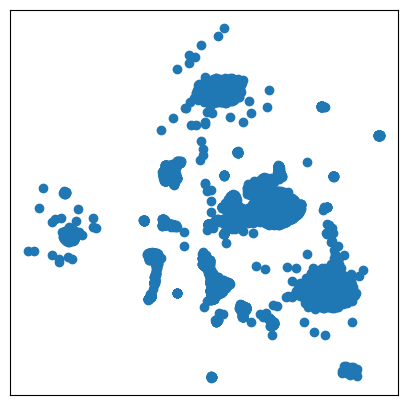

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5, 5))
plt.xticks([]), plt.yticks([])
scat_ = plt.scatter(x = viz_embeddings[:,0], y = viz_embeddings[:,1])

#### Cluster the data points 

In [10]:
fitted_model_ = hdbscan(reduced_embeddings)

In [11]:
labels_ = fitted_model_.labels_ 

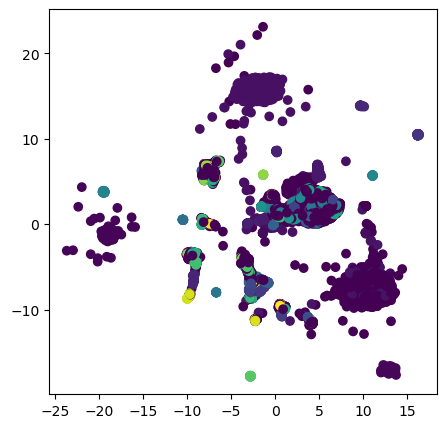

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5, 5))
scat_ = plt.scatter(x = viz_embeddings[:,0], y = viz_embeddings[:,1], c = fitted_model_.labels_)

#### Save to our vector database

In [13]:
documents.shape, embeddings.shape, reduced_embeddings.shape

((11000,), (11000, 768), (11000, 50))

In [7]:
chroma_client.delete_collection("cleaned-gh2024")

In [25]:
try: collection = chroma_client.get_collection(name = "cleaned-gh2024")
except: collection = chroma_client.create_collection(name="cleaned-gh2024")

In [26]:
print(len(ids), len(documents), len(reduced_embeddings))

11000 11000 11000


In [27]:
import uuid

## Save the version where our embeddings are generated ourselves.

chunk_size = 1_000

for i in range(len(reduced_embeddings) // chunk_size):

    chunked_ids = ids[i * chunk_size: (i + 1) * chunk_size].tolist()
    chunked_documents = documents[i * chunk_size: (i + 1) * chunk_size].tolist()
    chunked_embeddings = reduced_embeddings[i * chunk_size: (i + 1) * chunk_size].tolist()

    collection.upsert(
        documents = chunked_documents, 
        embeddings = chunked_embeddings, 
        ids = chunked_ids,
    )